<a href="https://colab.research.google.com/github/wiss0212/Super_resolution_3D_Model-/blob/main/Test_DIVASR_SR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/wiss0212/Super_resolution_3D_Model-.git

Cloning into 'Super_resolution_3D_Model-'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 9.97 KiB | 9.97 MiB/s, done.


model_060.hdf5
2023-05-23 19:58:24: load trained model architecture
(419, 402, 51)
1/1 [==============================] - 1s 711ms/step
(1, 419, 402, 51, 1)
DATA_TEST_SR : image:data_test.mat : time:6.0687 second
DATA_TEST_SR : psnr = 15.5758 : ssim = 0.7939


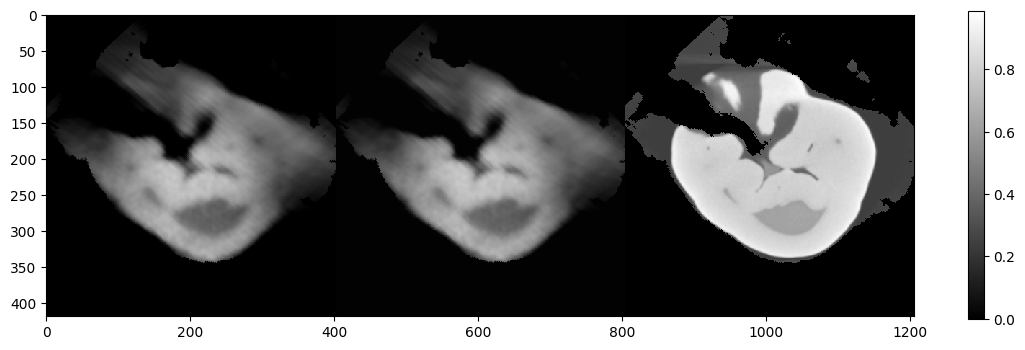

2023-05-23 19:58:35: Datset: DATA_TEST_SR 
  SNR_in = 8.77 dB, PSNR_in = 15.43 dB, SSIM_in = 0.8449
2023-05-23 19:58:35: PSNR = 15.58 dB, SSIM = 0.7939


In [ ]:
import argparse
from argparse import ArgumentParser
import glob
#import cv2
import re
import os, glob, datetime
import numpy as np
import tensorflow as tf
import numpy as np
import time
import math
from tensorflow.keras.layers import  Input,Conv3D,BatchNormalization,Activation,Subtract, Reshape
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils import conv_utils
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from skimage.transform import rescale
from scipy.io import loadmat
import scipy.io as sio
from scipy.io import savemat
from matplotlib import pyplot as plt
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.io import imread, imsave

#from skimage.measure import compare_psnr, compare_ssim



parser = argparse.ArgumentParser(description='Keras DIVA3D test')
# choose if needed
parser.add_argument('--model', default='DIVA3D', type=str, help='choose a type of model')
parser.add_argument('--kernel_size', default=3, type=int, help='kernel size')

parser.add_argument('--set_dir', default='/content/drive/MyDrive/Colab Notebooks/', type=str, help='directory of test dataset')
parser.add_argument('--set_names', default=['DATA_TEST_SR'], type=list, help='name of test dataset')
                                              # TOOTH_MU_CT_test

#parser.add_argument('--sigma', default=5, type=int, help='noise level - Choose a sigma value from 0 to 12')
parser.add_argument('--model_dir', default=os.path.join('/content/drive/MyDrive/Colab Notebooks/models',
                                                        'DIVA3D_CBCT_SR2'), type=str, help='directory of the model')

parser.add_argument('--model_name', default='model_060.hdf5', type=str, help='the model name')
#parser.add_argument('--result_dir', default=os.path.join(directory_path,'results'), type=str, help='directory of results')
parser.add_argument('--save_result', default=1, type=int, help='save the denoised image, 1 or 0')

parser.add_argument('-f', '--file', required=False)
args = parser.parse_args()

args.result_dir = os.path.join(args.model_dir,'results')



#########--------------           IMPORTANT NOTE       ----------------###############

# Please modify the 'args.sigma' by the respective sigma vamue
# Also change the 'args.model_dir' and the 'args.model_name' as defined below.


#print(args.sigma)
print(args.model_name)

# Also set 'use_model = False / True ' (which load pretrained models)
use_model = True


##--------------------------------------------------------------------------------------------------------
##--------------------------------------------------------------------------------------------------------

##--------------------------------------------------------------------------------------------------------
class Hamiltonian_Conv3D(Conv3D):

    def __init__(self, filters, kernel_size, kernel_3=None, kernel_4=None, activation=None, **kwargs):

        self.rank = 3               # Dimension of the kernel
        self.num_filters = filters  # Number of filter in the convolution layer
        self.kernel_size = conv_utils.normalize_tuple(kernel_size, self.rank, 'kernel_size')
        self.kernel_3 = kernel_3    # Weights from original potential
        self.kernel_4 = kernel_4    # Weights from interaction

        super(Hamiltonian_Conv3D, self).__init__(self.num_filters, self.kernel_size,
              activation=activation, use_bias=False, **kwargs)

    def build(self, input_shape):
        if K.image_data_format() == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                     'should be defined. Found `None`.')

        #don't use bias:
        self.bias = None

        #consider the layer built
        self.built = True


        # Define nabla operator
        weights_1 = tf.constant([[[ 3.,-1., 0.],
                                  [-1.,-1., 0.],
                                  [ 0., 0., 0.]],
                                  [[-1.,-1., 0.],
                                  [-1., 6.,-1.],
                                  [ 0.,-1.,-1.]],
                                 [[ 0., 0., 0.],
                                  [ 0.,-1.,-1.],
                                  [ 0.,-1., 3.]]])

        weights_1 = tf.reshape(weights_1 , [3,3,3, 1])
        weights_1 = tf.repeat(weights_1 , repeats=self.num_filters, axis=3)
        #print('kernel shape of weights_1:',weights_1.get_shape())

        # Define Weights for h^2/2m  (size should be same as the nabla operator)
        weights_2 = self.add_weight(shape=weights_1.get_shape(),
                                      initializer= 'Orthogonal',
                                      name='kernel_h^2/2m',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        #print('kernel shape of weights_2:',weights_2.get_shape())


        # Define the Hamiltonian kernel
        self.kernel = weights_1*weights_2 + self.kernel_3 + self.kernel_4
        #print('self.kernel',self.kernel.get_shape())

        self.built = True
        super(Hamiltonian_Conv3D, self).build(input_shape)

    # Do the 3D convolution using the Hamiltonian kernel
    def convolution_op(self, inputs, kernel):
        if self.padding == "causal":
            tf_padding = "VALID"  # Causal padding handled in `call`.
        elif isinstance(self.padding, str):
            tf_padding = self.padding.upper()
        else:
            tf_padding = self.padding


        return tf.nn.convolution(
            inputs,
            kernel,
            strides=list(self.strides),
            padding=tf_padding,
            dilations=list(self.dilation_rate),
            data_format=self._tf_data_format,
            name=self.__class__.__name__,
        )

    def call(self, inputs):
        outputs = self.convolution_op(inputs, self.kernel)
        return outputs




# -------------------------------------------------------------------------------------------------------------------

def DIVA3D(depth,filters=64,image_channels=1, kernel_size= args.kernel_size, use_bnorm=True):
    layer_count = 0
    inpt = Input(shape=(None,None,None,image_channels),name = 'input'+str(layer_count))

    # Get the initial patches /initial_patches
    initial_patches = Conv3D(filters=filters, kernel_size=(kernel_size,kernel_size,kernel_size), strides=(1,1,1),kernel_initializer='Orthogonal', padding='same',name = 'initial_patches')(inpt)
    initial_patches = Activation('relu',name = 'initial_patch_acti')(initial_patches)
    #print(initial_patches.get_shape())

    # interaction layer
    inter = Conv3D(filters=filters, kernel_size=(kernel_size,kernel_size,kernel_size), strides=(1,1,1),kernel_initializer='Orthogonal', padding='same',name = 'interactions')(initial_patches)
    inter = Activation('relu',name = 'interaction_acti'+str(layer_count))(inter)
    #print(inter.get_shape())


    # Get contributions of the original potential in the Hamiltonian kernel
    ori_poten_kernel = tf.keras.layers.MaxPooling3D (pool_size=(21,21,21), strides=(15,15,15), padding='same', name = 'ori_poten_ker', data_format=None )(initial_patches)
    #print('ori_poten_kernel',ori_poten_kernel.get_shape())

    # Get contributions of the interactions in the Hamiltonian kernel
    inter_kernel = tf.keras.layers.MaxPooling3D (pool_size=(21,21,21), strides=(15,15,15), padding='same', name = 'inter_ker', data_format=None )(inter)
    #print('inter_kernel',inter_kernel.get_shape())


    # Get projection coefficients of the initial patches on the Hamiltonian kernel
    x = Hamiltonian_Conv3D(filters=filters, kernel_size=(kernel_size,kernel_size,kernel_size), kernel_3 = ori_poten_kernel, kernel_4 = inter_kernel, strides=(1,1,1), activation='relu',
                              kernel_initializer='Orthogonal', padding='same', name = 'proj_coef')(initial_patches)

    #print('coef',x.get_shape())


    # Do Thresholding (depth depends on the noise intensity)
    for i in range(depth+10):
      layer_count += 1
      x = Conv3D(filters=filters, kernel_size=(kernel_size,kernel_size,kernel_size), strides=(1,1,1),kernel_initializer='Orthogonal', padding='same',use_bias = False,name = 'conv'+str(layer_count))(x)

      layer_count += 1
      x = BatchNormalization(axis=4, momentum=0.1,epsilon=0.0001, name = 'bn'+str(layer_count))(x)
        #x = BatchNormalization(axis=4, momentum=0.0,epsilon=0.0001, name = 'bn'+str(layer_count))(x)

      # Thresholding
      x = Activation('relu',name = 'Thresholding'+str(layer_count))(x)

    # Inverse projection
    x = Conv3D(filters=image_channels, kernel_size=(kernel_size,kernel_size,kernel_size), strides=(1,1,1), kernel_initializer='Orthogonal',padding='same',use_bias = False,name = 'inv_trans')(x)

    x = Subtract(name = 'subtract')([inpt, x])

    model = Model(inputs=inpt, outputs=x)

    return model

##----------------------------------------------------------------------------------------------------------------------



def to_tensor(img):
    return img[np.newaxis,...,np.newaxis]


def from_tensor(img):
    return np.squeeze(np.moveaxis(img[...,0],0,-1))

def log(*args,**kwargs):
     print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"),*args,**kwargs)

def save_result(result,path):
    path = path if path.find('.') != -1 else path+'.png'
    ext = os.path.splitext(path)[-1]
    if ext in ('.txt','.dlm'):
        np.savetxt(path,result,fmt='%2.4f')
    else:
        imsave(path,np.clip(result,0,1))


def show(x,title=None,cbar=False,figsize=None):
    import matplotlib.pyplot as plt
    plt.figure(figsize=figsize)
    plt.imshow(x,interpolation='nearest',cmap='gray')
    if title:
        plt.title(title)
    if cbar:
        plt.colorbar()
    plt.show()

def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = np.sqrt(np.mean(diff ** 2.))

    return 20 * np.log10(1. / rmse)


def snr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)

    diff = ref_data - target_data
    diff = diff.flatten('C')
    target_data = target_data.flatten('C')

    rmse_diff = np.sqrt(np.mean(diff ** 2.))
    rmse_target = np.sqrt(np.mean(target_data ** 2.))

    return 20 * np.log10(rmse_target / rmse_diff)


##----------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------
## -------------------------------------------------------------------------------------------------------------


if __name__ == '__main__':

    if  use_model:
        #choose model depth and filters number
        model = DIVA3D(depth=20,filters=64,image_channels=1,use_bnorm=True)
        model.load_weights(os.path.join(args.model_dir, args.model_name))
        log('load trained model architecture')
    else:
        print('Model- ',args.model)
        model = load_model(os.path.join(args.model_dir, args.model_name),compile=False)
        log('load trained model')

    if not os.path.exists(args.result_dir):
        os.mkdir(args.result_dir)


#-----------------------------------------------------------------------------------------------------------------------------------
#-----------------------------------------------------------------------------------------------------------------------------------

    for set_cur in args.set_names:

        if not os.path.exists(os.path.join(args.result_dir,set_cur)):
            os.mkdir(os.path.join(args.result_dir,set_cur))
        snrs_in = []
        psnrs_in = []
        ssims_in = []
        psnrs = []
        ssims = []

        for im in os.listdir(os.path.join(args.set_dir,set_cur)):
            if im.endswith(".mat"):

                I = loadmat(os.path.join(args.set_dir,set_cur,im))
                          # the CT gray scale image
                I_0 = I['MCT']
                I_2 = I['CBCT']
                I_1 = (I_0 - np.min(I_0))
                x = (I_1/ np.max(I_1))   # normalized the image
                print(x.shape)
                np.random.seed(seed=0) # for reproducibility

                # cbct_data

                I_3 = (I_2 - np.min(I_2))
                y = (I_3/ np.max(I_3))   # normalized the image
                y = y.astype(np.float32)

                y_  = to_tensor(y)
               # print(y_.shape)
                start_time = time.time()
                x_ = model.predict(y_) # inference
                print(x_.shape)

                elapsed_time = time.time() - start_time
                print('%10s : image:%10s : time:%2.4f second'%(set_cur,im,elapsed_time))

                x_=from_tensor(x_)

                # calculate for Gaussian noise
                snr_y = snr(x, y)        # input SNR
                psnr_y = psnr(x, y)      # input PSNR
                ssim_y = ssim(x, y)      # input SSIM
                psnr_x_ = psnr(x, x_)
                ssim_x_ = ssim(x, x_)
                print('%10s : psnr = %2.4f : ssim = %1.4f'%(set_cur,psnr_x_, ssim_x_))



                if args.save_result:
                    name, ext = os.path.splitext(im)

                    # showing image
                    show(np.hstack((y[:,:,50],x_[:,:,50],x[:,:,50])),figsize=(14, 4),cbar=True) # show the image

                    img_data = {'img_noi' : y,    'img_denoi' : x_,}
                    savemat(os.path.join(args.result_dir,set_cur,name+'_denoised_DIVA3D_sigma'+str(args.model_name)+'.mat'), img_data) # save the 3D images

                snrs_in.append(snr_y)     # input SNR
                psnrs_in.append(psnr_y)   # input PSNR
                ssims_in.append(ssim_y)   # input SSIM
                psnrs.append(psnr_x_)
                ssims.append(ssim_x_)


        snr_in_avg = np.mean(snrs_in)     # average input SNR
        psnr_in_avg = np.mean(psnrs_in)   # average input PSNR
        ssim_in_avg = np.mean(ssims_in)   # average input SSIM
        psnr_avg = np.mean(psnrs)
        ssim_avg = np.mean(ssims)

        snrs_in.append(snr_in_avg)      # input SNR
        psnrs_in.append(psnr_in_avg)    # input PSNR
        ssims_in.append(ssim_in_avg)    # input SSIM
        psnrs.append(psnr_avg)
        ssims.append(ssim_avg)

        if args.save_result:
            save_result(np.hstack((psnrs, ssims)),path=os.path.join(args.result_dir,set_cur,'divaSR_results.txt'))
            save_result(np.hstack((snrs_in, psnrs_in, ssims_in)),path=os.path.join(args.result_dir,set_cur,'divaSR_results_input.txt'))

        log('Datset: {0:10s} \n  SNR_in = {1:2.2f} dB, PSNR_in = {2:2.2f} dB, SSIM_in = {3:1.4f}'.format(set_cur, snr_in_avg, psnr_in_avg, ssim_in_avg))
        log('PSNR = {0:2.2f} dB, SSIM = {1:1.4f}'.format(psnr_avg, ssim_avg))

